<a href="https://colab.research.google.com/github/Shrishml/Stock_analysis/blob/main/lstm_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock prices follows Brownian motion, making it very difficult to predict. I personally do not belive in technical trading. I am just explroing some the deep learning techniques to predict the stock price.**

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 Installing quandl

 
 We will take data of HDFC bank from BSE.

In [2]:
!pip install quandl

In [3]:
import quandl

In [4]:
my_data =  quandl.get('BSE/BOM500180', start_date='2000-03-13', end_date='2021-08-09')
my_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2000-03-13,245.0,276.45,245.0,276.0,265.231550,200186.0,1340.0,53095643.0,NaN,NaN,31.45,31.0
2000-03-14,273.0,279.00,260.0,268.9,265.145800,120466.0,1219.0,31941054.0,NaN,NaN,19.00,-4.1
2000-03-15,265.0,265.00,256.0,259.0,259.383217,97193.0,807.0,25210233.0,NaN,NaN,9.00,-6.0
2000-03-16,258.0,261.95,255.0,256.9,257.744817,148239.0,1134.0,38207834.0,NaN,NaN,6.95,-1.1
2000-03-21,257.0,260.90,238.0,254.5,252.782404,96077.0,839.0,24286575.0,NaN,NaN,22.90,-2.5


In [ ]:
def adjust_stock_split(my_data, split_dates, split_val):
    split_dates = pd.to_datetime(split_dates).sort_values()
    for i in range(len(split_dates)):
        my_data.Close[my_data.index<split_dates[i]]= my_data.Close[my_data.index<split_dates[i]]/split_val[i]
    return my_data

quandl BSE data is not giving adjusted close price, it does not account for stock split. So we have to do it externally.

In [5]:
my_data.Close[my_data.index<pd.to_datetime('14-07-2011')]= my_data.Close[my_data.index<pd.to_datetime("14-07-2011")]/5 # 5 split

my_data.Close[my_data.index< pd.to_datetime('2019-09-19')]= my_data.Close[my_data.index< pd.to_datetime('2019-09-19')]/2 # 2 split

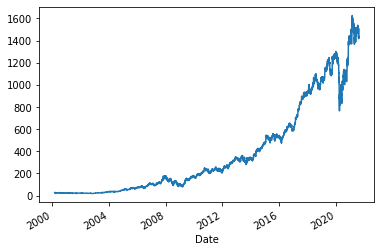

In [6]:
my_data['Close'].plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler

We make the last 10 days of data as the input data and data of 11th day as output data.

Here, We are just trying to predict the one day data.

Which is not very useful though.

In [8]:
cl = my_data.Close.astype('float32')
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)

my_data['Close_scaled']=cl

def processData(data,lb):
    new_data = pd.DataFrame(index = my_data.index, data=np.array([data.Close_scaled.shift(-1*i).values for i in range(lb)]).T)
    Y=my_data['Close'].iloc[lb:].values
    X=new_data.values
    return np.array(X[:len(data)-lb-1]),np.array(Y[:len(data)-lb-1])

lb=10
X,y = processData(my_data,lb)

X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

4783 10
532 10
4783
532


In [9]:
from keras.layers import LSTM
from keras import Sequential
from keras.layers import Dense

We train LSTM(Long Short Term Memory) model with the data.

In [ ]:
model = Sequential()

model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
model.summary()

Epoch 1/300
150/150 [==============================] - 23s 37ms/step - loss: 19770.7268 - val_loss: 1396225.6250
Epoch 2/300
150/150 [==============================] - 5s 32ms/step - loss: 17896.1188 - val_loss: 1342161.7500
Epoch 3/300
150/150 [==============================] - 5s 32ms/step - loss: 18102.9943 - val_loss: 1296413.8750
Epoch 4/300
150/150 [==============================] - 5s 32ms/step - loss: 19101.3085 - val_loss: 1256339.0000
Epoch 5/300
150/150 [==============================] - 5s 31ms/step - loss: 20669.8225 - val_loss: 1221913.8750
Epoch 6/300
150/150 [==============================] - 5s 32ms/step - loss: 24357.3974 - val_loss: 1267598.8750
Epoch 7/300
150/150 [==============================] - 5s 32ms/step - loss: 15408.5872 - val_loss: 1226429.1250
Epoch 8/300
150/150 [==============================] - 5s 32ms/step - loss: 22198.0869 - val_loss: 1198727.7500
Epoch 9/300
150/150 [==============================] - 5s 31ms/step - loss: 23151.0018 - val_loss: 1111

In [ ]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

In [ ]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")